In [2]:
print('hello')

hello


[*********************100%***********************]  1 of 1 completed
buy2018-06-08 00:00:00
利確2018-08-27 00:00:00
buy2018-08-28 00:00:00
損切り2018-10-11 00:00:00
buy2019-02-22 00:00:00
利確2019-05-13 00:00:00
buy2019-06-20 00:00:00
利確2019-09-09 00:00:00
buy2019-10-24 00:00:00
利確2020-01-13 00:00:00
buy2020-01-15 00:00:00
損切り2020-02-26 00:00:00
buy2020-06-01 00:00:00
利確2020-08-20 00:00:00
buy2020-08-21 00:00:00
利確2020-11-09 00:00:00
buy2020-11-13 00:00:00
利確2021-02-01 00:00:00
2018-01-01から現在まで
トータルリターンは25.68 %
平均リターンは5.08%
平均損失は-5.55%
勝率は77.77777777777777%
取引回数は9
-------------------------------------------


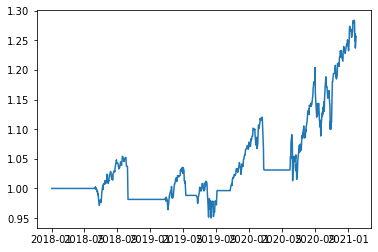

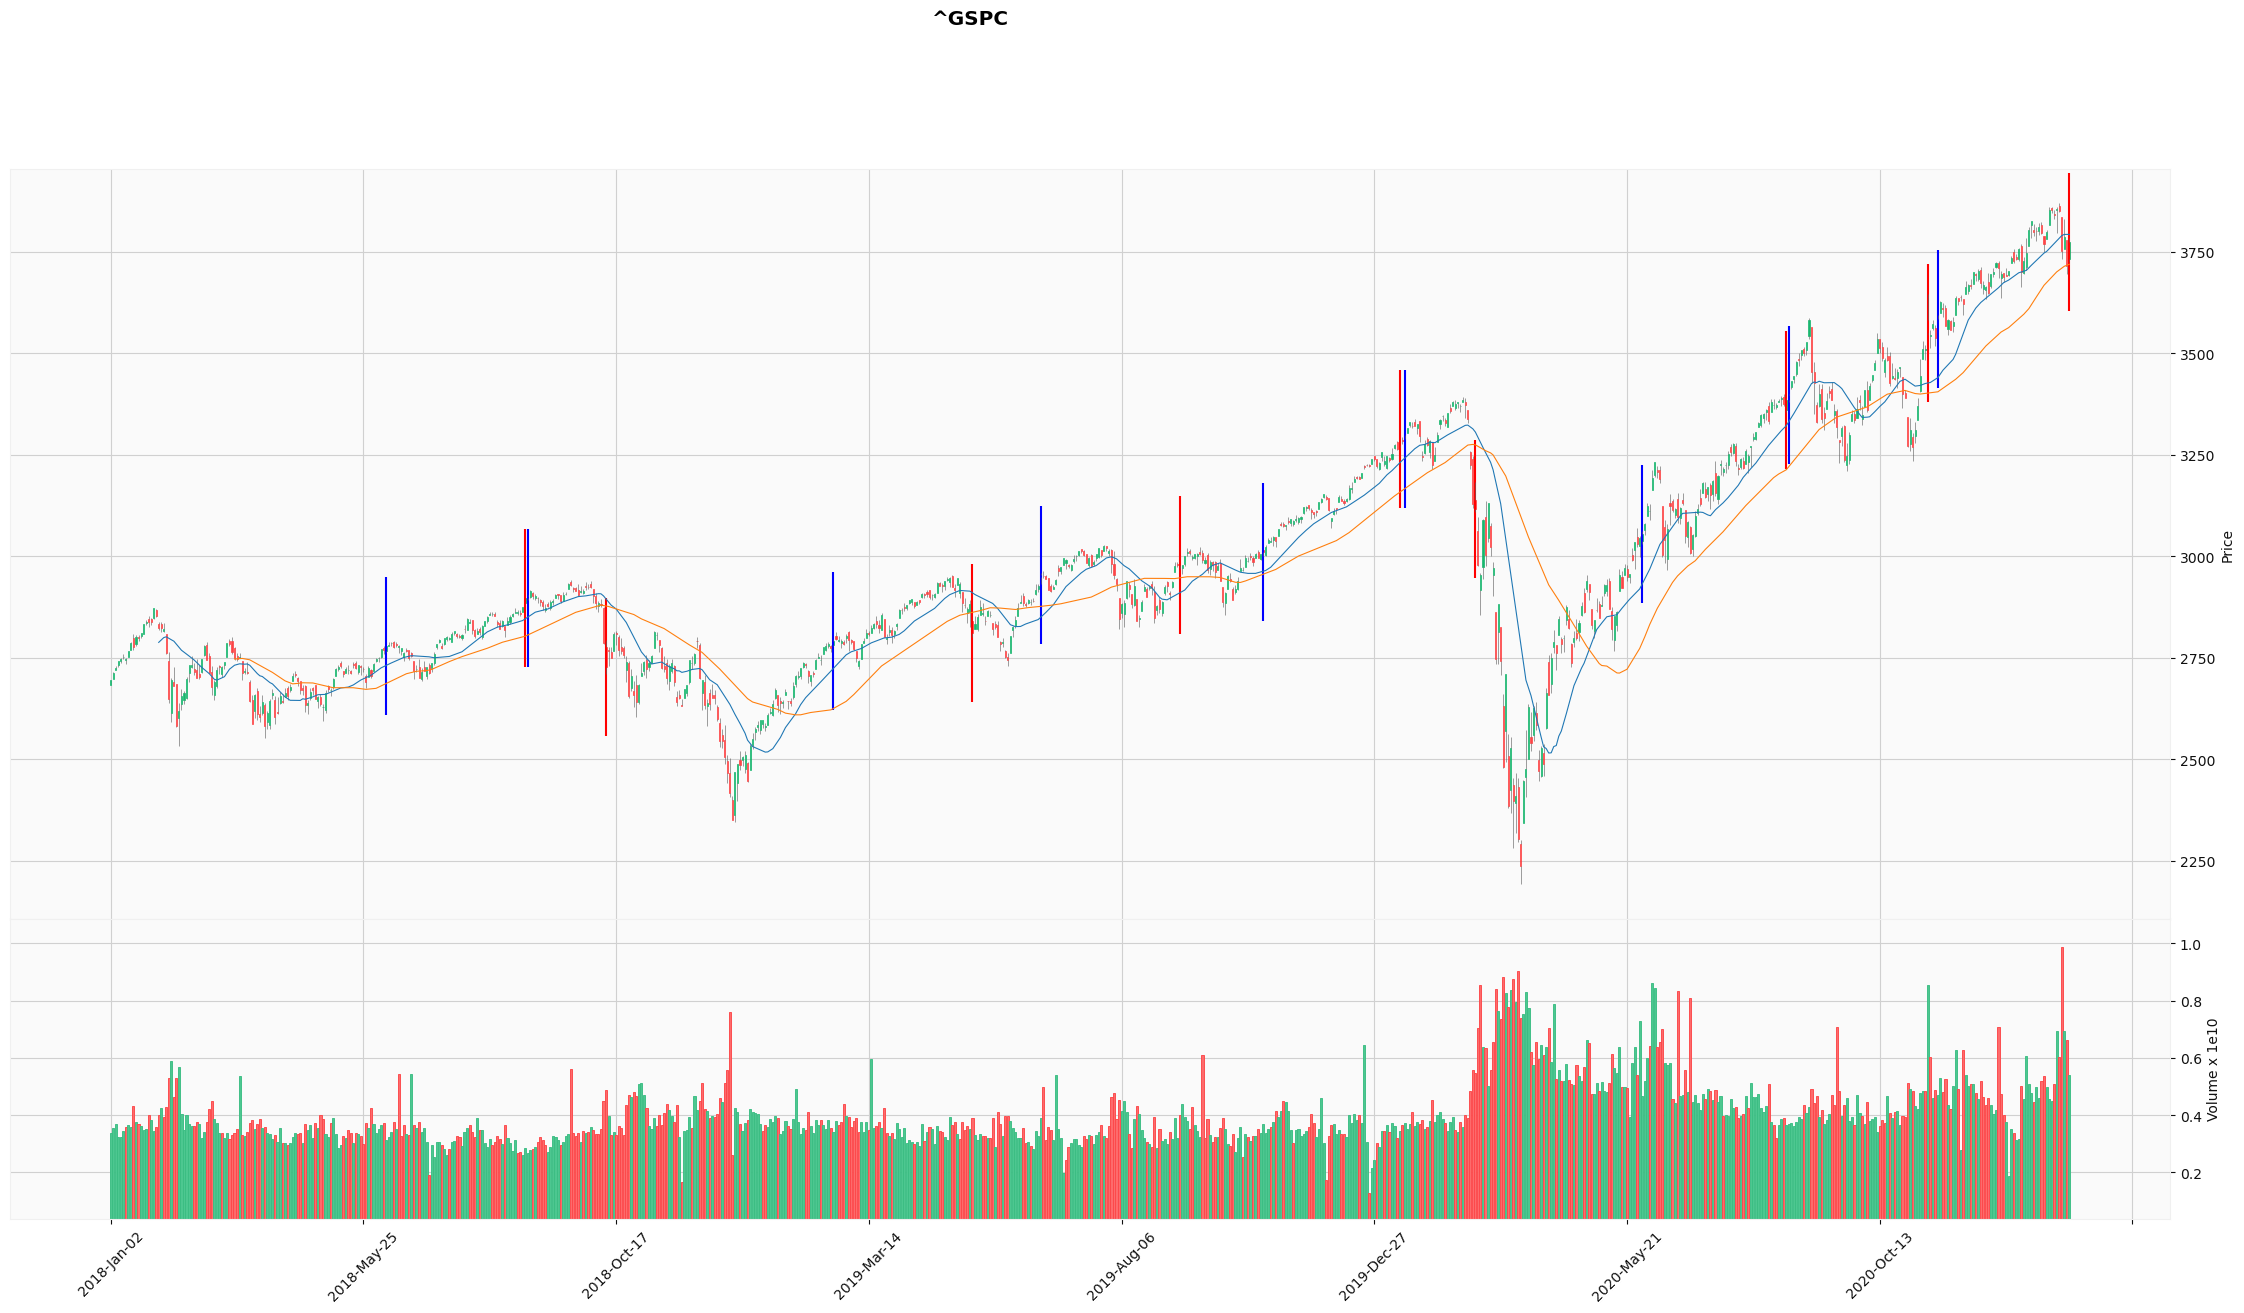

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpl

start = '2018-01-01'
end = '2021-02-02'
stock_code = '^GSPC' 
df = yf.download(stock_code, start, end, interval='1d') 
term = 60

# chek the highest price in the past {term} times
df['Highest'+str(term)] = df.iloc[:, 4].rolling(window=term).max()
# chek the highest price in the past {term} times
df['Lowest'+str(term)] = df.iloc[:, 4].rolling(window=term).min()


"""
メインループ
基本戦略
過去longTerm間の調整済み終値の最高値をその日の調整済み終値が更新したら購入
損切り率は5%。80日後に利確する。
最終日にまだ保持していた場合捌く
"""
# 資産、購入したときの資産
assets = [1]
buy_asset = 1
# 買いポジションは０にする
buy_position = False

# 損切り率と利確の日数
stopLoss = 0.95
rikaku_day = 80

#買い日と売り日
buy_days = []
sell_days = []

# calculation SMA
short_sma = 20
long_sma = 50


counter=0
percentChange = []
for i in range(1, len(df)):
    Highest = df['Highest'+str(term)][i-1]
    Lowest = df['Lowest'+str(term)][i-1]
    high_price = df['High'][i]
    low_price = df['Low'][i]
    close = df['Adj Close'][i]
    open_price = df['Open'][i]
    last_close = df['Close'][i-1]
    last_high = df['High'][i-1]
    sellday = pd.to_datetime(df.index[i])


    if buy_position == False:
        assets.append(assets[i-1])
    else:
        assets.append(buy_asset*(close / buy_price))

    # avoid NaN data 買いトレンド
    if np.isnan(Highest) == False:
        if (close > Highest and buy_position == False):
            buy_position = True
            buy_price = close
            buy_stopLine = close * stopLoss
            buy_asset = assets[i]
            buyday = pd.to_datetime(df.index[i])
            print('buy'+str(df.index[i]))
            buy_days.append(df.index[i])
    
     # 損切り
    if buy_position == True and close < buy_stopLine:
        buy_position = False 
        percent = (close/buy_price - 1) * 100
        percentChange.append(percent)
        sell_days.append(df.index[i])
        #buy_dates = 0
        print('損切り'+str(df.index[i]))
        #print('Date:'+str(i),'Stop Loss Buy at the price {}'.format(close))


    
    # 利確
    if buy_position == True and (sellday-buyday).days > 79:
        buy_position = False
        percent = (close/buy_price - 1) * 100
        percentChange.append(percent)
        print('利確'+str(df.index[i]))
        sell_days.append(df.index[i])

    #  最終日にまだ持ってたら利確する
    if (counter == df['Adj Close'].count() - 1):
        if buy_position == True:
            buy_position = False
            percent = (close / buy_price - 1) * 100
            percentChange.append(percent)
            sell_days.append(i)
            print('Date:'+str(i),'Last Day Buy at the price {}'.format(close))

    counter += 1


#print(percentChange)

# statistic
gains = 0
numgains = 0
losses = 0
numlosses = 0
total_return = 1


for i in percentChange:
    if i > 0:
        numgains += 1
        gains += i
    else:
        numlosses += 1
        losses += i
    total_return = total_return * ((i / 100) + 1)



            
print('{}から現在まで'.format(start))
print('トータルリターンは{} %'.format(round(100*(total_return-1),2)))
print('平均リターンは'+str(round(gains/numgains,2))+'%')
print('平均損失は'+str(round(losses/numlosses,2))+'%')
print('勝率は'+str(100*numgains/(numgains+numlosses))+'%')
print('取引回数は'+str(numgains+numlosses))
print('-------------------------------------------')



#資産曲線
assets = np.array(assets)
#print(assets)
#print(assets.min())
#print('{}%'.format((round((1-assets.min())*100,2))))
plt.plot(df.index,assets)
plt.show()


 #sp５００

buy_signals = []
sell_signals = []
for i in df.index:
    if i in buy_days:
        buy_signals.append(df['Adj Close'][i])
    else:
        buy_signals.append(np.nan)
    if i in sell_days:
        sell_signals.append(df['Adj Close'][i])
    else:
        sell_signals.append(np.nan)
        


adp = [
    mpl.make_addplot(buy_signals, type='scatter', markersize=10000, marker='|', color="b"),
    mpl.make_addplot(sell_signals, type='scatter', markersize=10000, marker='|', color="r")
]
fig = mpl.plot(df, type='candle',figsize=(30, 15),mav=(short_sma, long_sma),
               addplot=adp, style='yahoo', volume=True,  title=str(stock_code), returnfig=True)

